In [1]:
import xarray as xr
from act.io import read_icartt
from datetime import datetime as dt
from glob import glob
from os import path
import pandas as pd
import numpy as np
import warnings
from metpy.units import units
from metpy import calc as mpcalc
from metpy.plots import USCOUNTIES, SkewT

import pandas as pd

from associate_obs import identify_side

from matplotlib import pyplot as plt
from cartopy import crs as ccrs
from cartopy import feature as cfeat


## ---------------------------------- SOUNDERPY ----------------------------------- ##
##          Vertical Profile Data Retrieval and Analysis Tool For Python            ##
##                      v3.0.8 | Jan 2025 | (C) Kyle J Gillett                      ##
##                 Docs: https://kylejgillett.github.io/sounderpy/                  ##
## --------------------- THANK YOU FOR USING THIS PACKAGE! ------------------------ ##


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [ ]:
def identify_aircraft_below_feature(air_ds, tfm):
    in_feature_times = identify_side(air_ds.time.data.astype('datetime64[s]').astype(float), air_ds.lon.data, air_ds.lat.data, tfm.time.data.astype('datetime64[s]').astype(float),
              tfm.segmentation_mask.transpose('time', *tfm.lat.dims).compute().data, tfm.lon.data, tfm.lat.data)
    air_ds['inside_feature'] = xr.DataArray(in_feature_times, dims='time')
    closest_to_tfm_time_indices = np.argmin(np.abs(air_ds.time.data[:, None] - tfm.time.data), axis=1)
    air_ds['closest_tfm_time'] = xr.DataArray(tfm.time.data[closest_to_tfm_time_indices], dims='time')
    features_to_select = np.unique(in_feature_times)
    features_to_select = features_to_select[~np.isnan(features_to_select)]
    cloud_passes = tfm.sel(feature=features_to_select)
    ccl_hpa = cloud_passes.feature_ccl
    indices_of_profile_ccl = xr.ufuncs.absolute(cloud_passes.feature_pressure_profile - ccl_hpa).argmin(dim='vertical_levels')
    ccl_z = cloud_passes.feature_msl_profile.isel(vertical_levels=indices_of_profile_ccl)
    below_feature = np.zeros(air_ds.inside_feature.data.shape, dtype=bool)
    for cap_to_check in ccl_z:
        spec_idx_inside_feat = np.where(air_ds.inside_feature.data == cap_to_check.feature.data)[0]
        below_feature_mask = air_ds.alt[spec_idx_inside_feat] < cap_to_check.data
        below_feature[spec_idx_inside_feat] = below_feature_mask
    air_ds['below_feature'] = xr.DataArray(below_feature, dims='time')
    return air_ds

In [3]:
date_i_want = dt(2022, 6, 2)

In [4]:
tfm = xr.open_dataset('/Volumes/LtgSSD/tobac_saves/tobac_Save_20220602/seabreeze-obs.zarr', engine='zarr')

In [ ]:
spec_flight_dirs = sorted(glob(f'/Volumes/LtgSSD/air_SPEC_state/RF*_ict_{date_i_want.strftime("%Y%m%d")}*'))
spec_ds = []
for spec_flight_dir in spec_flight_dirs:
    page0_data_path = path.join(spec_flight_dir, f'ESCAPE-Page0_Learjet_{date_i_want.strftime("%Y%m%d")}_R0.ict')
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ds = read_icartt(page0_data_path)
    
    rf_num = path.basename(spec_flight_dir).split('_')[0]
    spec_hires_position_dir = f'/Volumes/LtgSSD/AircraftTracks/Learjet/L_{rf_num}/'
    spec_hires_position_file = glob(spec_hires_position_dir+'*.txt')[0]
    nonpublic_df = pd.read_csv(spec_hires_position_file, sep='\\s+')
    nonpublic_df['pydatetime'] = pd.to_datetime(nonpublic_df['yyyy'].astype(str).str.zfill(4) +
                                            nonpublic_df['month'].astype(str).str.zfill(2) +
                                            nonpublic_df['day'].astype(str).str.zfill(2) +
                                            nonpublic_df['hh'].astype(str).str.zfill(2) +
                                            nonpublic_df['mm'].astype(str).str.zfill(2) +
                                            nonpublic_df['ss'].astype(str).str.zfill(2), format='%Y%m%d%H%M%S')
    trimmed_npdf = nonpublic_df[(nonpublic_df['pydatetime'] >= ds.time.data[0]) & (nonpublic_df['pydatetime'] <= ds.time.data[-1])]
    if np.all(trimmed_npdf['pydatetime'].values == ds.time.data):
        ds['lat'] = xr.DataArray(trimmed_npdf['Latitude(deg)'].values, dims='time')
        ds['lon'] = xr.DataArray(trimmed_npdf['Longitude(deg)'].values, dims='time')

    spec_ds.append(ds)
if len(spec_ds) > 1:
    spec_ds = xr.concat(spec_ds, dim='time')
else:
    spec_ds = spec_ds[0]
spec_alt_ft = spec_ds.Palt * units.feet
spec_alt_m = spec_alt_ft.data.to('m').magnitude
spec_ds['alt'] = xr.DataArray(spec_alt_m, dims='time')

spec_ds = identify_aircraft_below_feature(spec_ds, tfm)
spec_below_cloud = spec_ds.isel(time=spec_ds['below_feature'].data)



nrc_flights = sorted(glob(f'/Volumes/LtgSSD/air_NRC_state/atmospheric-state_{date_i_want.strftime("%Y%m%d")}*.nc'))
nrc_ds = xr.open_mfdataset(nrc_flights).load().isel(sps1=0)
nrc_ds = identify_aircraft_below_feature(nrc_ds, tfm)
nrc_below_cloud = nrc_ds.isel(time=nrc_ds['below_feature'].data)

In [24]:
nrc_below_cloud

<xarray.Dataset> Size: 30kB
Dimensions:           (time: 161)
Coordinates:
  * time              (time) datetime64[ns] 1kB 2022-06-02T18:34:57 ... 2022-...
    sps1              int64 8B 0
Data variables: (12/23)
    lat               (time) float64 1kB 29.1 29.1 29.1 ... 29.08 29.08 29.08
    lon               (time) float64 1kB -94.97 -94.97 -94.97 ... -95.33 -95.33
    alt               (time) float64 1kB 495.0 494.3 ... 1.272e+03 1.272e+03
    vel-ns            (time) float64 1kB 73.22 73.32 73.34 ... -23.87 -23.67
    vel-ew            (time) float64 1kB -50.49 -50.68 -50.99 ... 86.67 86.81
    vel-v             (time) float64 1kB 0.8594 0.6744 0.4958 ... 0.4142 1.233
    ...                ...
    wspd              (time) float64 1kB 0.6885 1.241 1.229 ... 5.104 5.416
    wdir              (time) float64 1kB 95.45 106.4 96.24 ... 337.9 1.575 2.522
    wind_v            (time) float64 1kB 0.0598 0.534 0.4055 ... 0.365 -0.6551
    inside_feature    (time) float64 1kB 1.188e+04 1.188e+04 ... 1.484e+04
    closest_tfm_time  (time) datetime64[ns] 1kB 2022-06-02T18:35:34.532000 .....
    below_feature     (time) bool 161B True True True True ... True True True
Attributes: (12/21)
    Institution:            National Research Council of Canada (NRC)
    Address:                Flight Research Laboratory, NRC, Bldg. U-61, 1920...
    Project:                ESCAPE
    NRCProjectManager:      Dr. Keyvan Ranjbar
    NRCDataAuthors:         Mr. Kenny Bala, Dr. Mengistu Wolde
    PointOfContact:         Keyvan.Ranjbar@nrc-cnrc.gc.ca
    ...                     ...
    GeospatialLonMax:       -94.564288
    CenterCoordLat:         29.007969
    CenterCoordLon:         -95.082422
    time_coverage_start:    2022-06-02T15:05:01
    time_coverage_end:      2022-06-02T19:21:59
    TimeInterval:           15:05:01-19:21:59

In [ ]:

times_below_cloud = spec_below_cloud.time.data

In [8]:
tfm_below_cloud = tfm.sel(time=times_below_cloud, method='nearest')

In [9]:
tfm_below_cloud = tfm_below_cloud.isel(time=0)

In [10]:
below_cloud_time_index = np.argwhere(tfm.time.data == tfm_below_cloud.time.data)[0][0]

In [11]:
tfm_below_cloud = tfm_below_cloud.sel(feature=7063)

In [12]:
tfm_below_cloud.maritime_pressure_profile
this_sonde_data = pd.DataFrame({
    'pres' : tfm_below_cloud.maritime_pressure_profile.data,
    'tdry' : tfm_below_cloud.maritime_temperature_profile.data,
    'dp' : tfm_below_cloud.maritime_dewpoint_profile.data,
    'u_wind' : tfm_below_cloud.maritime_u_profile.data,
    'v_wind' : tfm_below_cloud.maritime_v_profile.data,
    'alt' : tfm_below_cloud.maritime_msl_profile.data
})
this_lon = np.mean(spec_below_cloud.lon)
this_lat = np.mean(spec_below_cloud.lat)
this_pydt = tfm_below_cloud.time.data.astype('datetime64[s]').astype('O').item()
sbf = -2

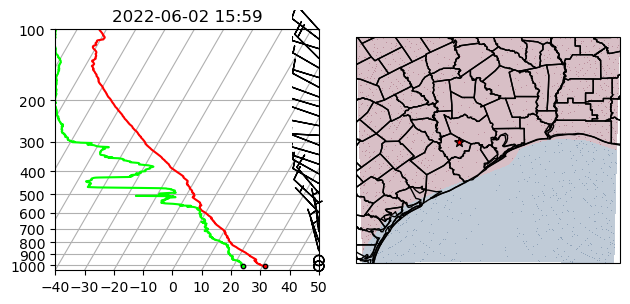

In [13]:
p = this_sonde_data['pres'].values
T = this_sonde_data['tdry'].values
Td = this_sonde_data['dp'].values
u = this_sonde_data['u_wind'].values
v = this_sonde_data['v_wind'].values
mask = mpcalc.resample_nn_1d(p,  np.logspace(4, 2))
fig = plt.figure()
if this_lon is None:
    skew = SkewT(fig, subplot=(1, 1, 1))
else:
    skew = SkewT(fig, subplot=(1, 2, 1))
    ax = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
skew.plot(p, T, 'r')
skew.plot(p, Td, 'lime')
skew.ax.scatter([T[0]], [p[0]], color='r', s=10, edgecolors='k', zorder=5)
skew.ax.scatter([Td[0]], [p[0]], color='lime', s=10, edgecolors='k', zorder=5)
skew.plot_barbs(p[mask], u[mask], v[mask])

skew.ax.set_title(f'{this_pydt.strftime("%Y-%m-%d %H:%M")}')
if this_lon is not None:
    if sbf == -1:
        ax.scatter(this_lon, this_lat, c='blue', s=50, marker='*', edgecolors='k', zorder=5)
    elif sbf == -2:
        ax.scatter(this_lon, this_lat, c='red', s=50, marker='*', edgecolors='k', zorder=5)
    nearest_sbf_time_idx = np.argmin(np.abs(tfm.time.data.astype('datetime64[s]').astype('O') - this_pydt))
    this_sbf = tfm.seabreeze.isel(time=nearest_sbf_time_idx)
    ax.pcolormesh(tfm.lon, tfm.lat, this_sbf.transpose(*tfm.lon.dims), transform=ccrs.PlateCarree(), zorder=1, alpha=0.25, cmap='RdBu')
    ax.add_feature(cfeat.STATES.with_scale('50m'))
    ax.add_feature(USCOUNTIES.with_scale('5m'))
fig.tight_layout()

In [14]:
spec_nearest_hPa = []
for i in range(spec_below_cloud.alt.data.shape[0]):
    this_alt = spec_below_cloud.alt.data[i]
    index_of_sonde_alt = np.argmin(np.abs(this_sonde_data.alt - this_alt))
    this_pressure = this_sonde_data.pres[index_of_sonde_alt]
    spec_nearest_hPa.append(this_pressure)

In [15]:
spec_nearest_hPa = np.array(spec_nearest_hPa)

In [16]:
skew.ax.scatter(spec_below_cloud.Temp.data, spec_nearest_hPa, color='red', s=10, edgecolors='k', zorder=5)

In [17]:
skew.ax.scatter(spec_below_cloud.Dew.data, spec_nearest_hPa, color='lime', s=10, edgecolors='k', zorder=5)

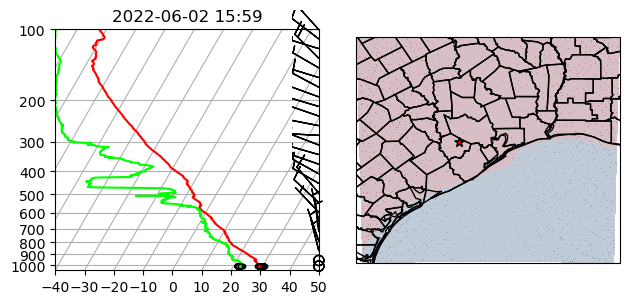

In [18]:
fig

In [19]:
spec_below_cloud

<xarray.Dataset> Size: 59kB
Dimensions:           (time: 223)
Coordinates:
  * time              (time) datetime64[ns] 2kB 2022-06-02T15:57:32 ... 2022-...
Data variables: (12/33)
    Time_Start        (time) float64 2kB 5.745e+04 5.745e+04 ... 5.767e+04
    TAS               (time) float64 2kB 6.0 6.0 6.0 6.0 ... 80.0 82.0 84.0 87.0
    Palt              (time) float64 2kB 45.0 45.0 45.0 45.0 ... 44.0 50.0 53.0
    Hdg               (time) float64 2kB 172.0 172.0 171.0 ... 349.0 348.0 349.0
    Temp              (time) float64 2kB 29.0 29.1 29.3 29.2 ... 28.4 28.6 28.6
    Dew               (time) float64 2kB 21.9 21.7 21.8 21.8 ... 21.3 21.5 22.4
    ...                ...
    lat               (time) float64 2kB 29.62 29.62 29.62 ... 29.62 29.63 29.63
    lon               (time) float64 2kB -95.66 -95.66 -95.66 ... -95.66 -95.66
    alt               (time) float64 2kB 13.72 13.72 13.72 ... 13.41 15.24 16.15
    inside_feature    (time) float64 2kB 7.063e+03 7.063e+03 ... 7.063e+03
    closest_tfm_time  (time) datetime64[ns] 2kB 2022-06-02T15:59:43.382000 .....
    below_feature     (time) bool 223B True True True True ... True True True
Attributes: (12/21)
    PI:                 Lawson, Paul
    PI_Affiliation:     SPEC Inc
    Platform:            Learjet35
    Mission:            ESCAPE 2022
    DateOfCollection:   (2022, 6, 2)
    DateOfRevision:     (2022, 7, 27)
    ...                 ...
    Project_Info:        ESCAPE Campaign, 2022-06-01-2022-06-21
    Stipulations:        Please contact PI or DM for stipulations or assistan...
    Comments:            if data are missing/bad, valus is -999.
    Revision:            R0
    Revision_Comments:   Final Data
    _datastream:        ESCAPE-Page0